In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

load dataset

In [149]:
df=pd.read_csv('crm_data_20k.csv')
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [150]:
df.shape

(19945, 12)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [152]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13


In [153]:
df.isnull().sum()

,0
master_id,0
order_channel,0
last_order_channel,0
first_order_date,0
last_order_date,0
last_order_date_online,0
last_order_date_offline,0
order_num_total_ever_online,0
order_num_total_ever_offline,0
customer_value_total_ever_offline,0


In [154]:
# Convert date columns
date_cols=[
    'first_order_date',
    'last_order_date',
    'last_order_date_online',
    'last_order_date_offline',
]
for col in date_cols:
    df[col]=pd.to_datetime(df[col])

In [155]:
df['total_orders'] = (
    df['order_num_total_ever_online']+
    df['order_num_total_ever_offline']
)

In [156]:
df['total_value'] = (
    df['customer_value_total_ever_online']+
    df['customer_value_total_ever_offline']
)

Recency Feature Engineering

In [157]:
reference_date = df['last_order_date'].max()

df['recency'] = (reference_date - df['last_order_date']).dt.days
df['tenure_days'] = (df['last_order_date'] - df['first_order_date']).dt.days

Target Variable Creation

In [158]:
df['high_value_customer'] = np.where(
    df['total_value'] > df['total_value'].median() ,1, 0
)
df['high_value_customer'].value_counts()


,count
high_value_customer,
0,9973
1,9972


Drop Raw DateTime Columns

In [159]:
df.drop(columns=date_cols,inplace=True)

Distribution Of Total Customer Value

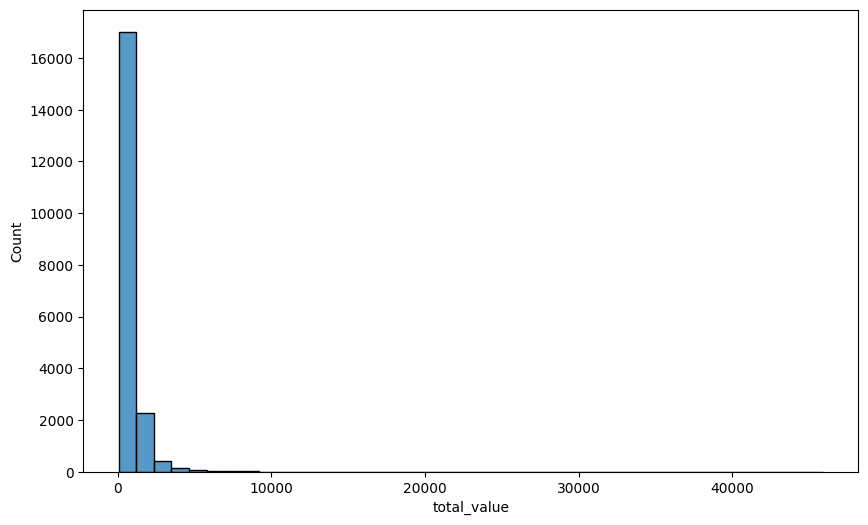

In [160]:
plt.figure(figsize=(10,6))
sns.histplot(df['total_value'],bins=40)
plt.show()


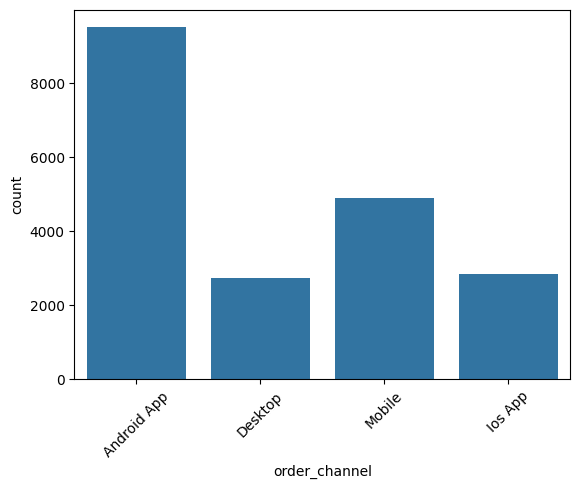

In [161]:
plt.figure()
sns.countplot(x='order_channel',data=df)
plt.xticks(rotation=45)
plt.show()

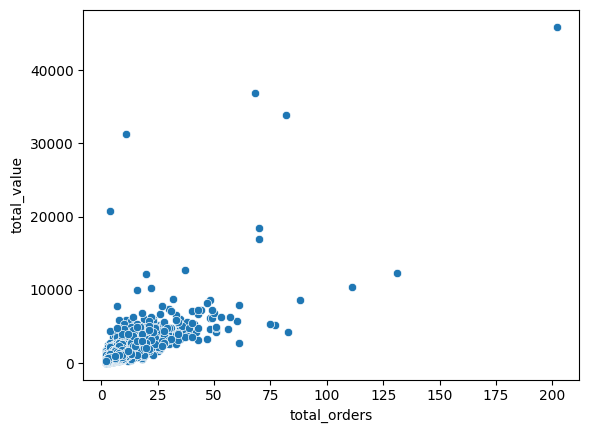

In [162]:
plt.figure()
sns.scatterplot(x='total_orders',y='total_value',data=df)
plt.show()

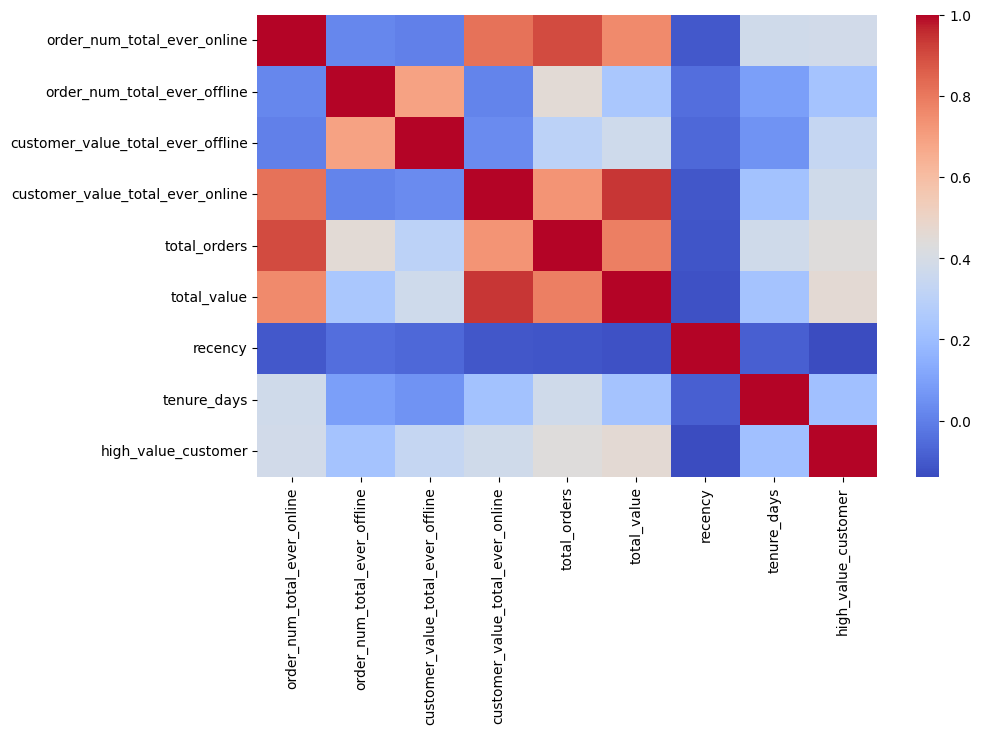

In [163]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(),cmap='coolwarm')
plt.show()


In [164]:
X=df.drop(['master_id','high_value_customer'],axis=1)
y=df['high_value_customer']

In [165]:
cat_cols=X.select_dtypes(include='object').columns
num_cols=X.select_dtypes(include=['int64','float64']).columns
cat_cols,num_cols

(Index(['order_channel', 'last_order_channel', 'interested_in_categories_12'], dtype='object'),
 Index(['order_num_total_ever_online', 'order_num_total_ever_offline',
        'customer_value_total_ever_offline', 'customer_value_total_ever_online',
        'total_orders', 'total_value', 'recency', 'tenure_days'],
       dtype='object'))

In [179]:
preprocessor=ColumnTransformer([
    ('num',StandardScaler(),num_cols),
    ('cat',OneHotEncoder(handle_unknown='ignore'),cat_cols)
])

In [180]:
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
log_model=Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',LogisticRegression(max_iter=1000))
])

log_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['order_num_total_ever_online', 'order_num_total_ever_offline',
       'customer_value_total_ever_offline', 'customer_value_total_ever_online',
       'total_orders', 'total_value', 'recency', 'tenure_days'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['order_channel', 'last_order_channel', 'interested_in_categories_12'], dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [182]:
y_pred_lr = log_model.predict(X_test)
print(("Accuracy:",accuracy_score(y_test,y_pred_lr)))
print(classification_report(y_test,y_pred_lr))

('Accuracy:', 0.9914765605414891)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1995
           1       1.00      0.99      0.99      1994

    accuracy                           0.99      3989
   macro avg       0.99      0.99      0.99      3989
weighted avg       0.99      0.99      0.99      3989



In [183]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())   # ← add ()
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['order_num_total_ever_online', 'order_num_total_ever_offline',
       'customer_value_total_ever_offline', 'customer_value_total_ever_online',
       'total_orders', 'total_value', 'recency', 'tenure_days'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['order_channel', 'last_order_channel', 'interested_in_categories_12'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

Random Forest Evolution

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
y_pred_rf = rf_model.predict(X_test)
print(("Accuracy:",accuracy_score(y_test,y_pred_rf)))
print(classification_report(y_test,y_pred_rf))


('Accuracy:', 1.0)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1995
           1       1.00      1.00      1.00      1994

    accuracy                           1.00      3989
   macro avg       1.00      1.00      1.00      3989
weighted avg       1.00      1.00      1.00      3989



Confusion Matrix

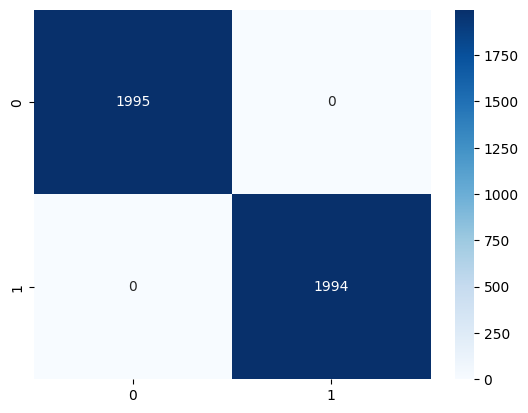

In [193]:
cm=confusion_matrix(y_test,y_pred_rf)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.show()

ROC Curve

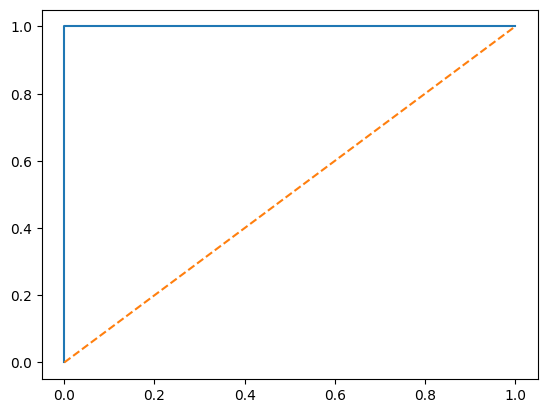

In [194]:
y_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'--')
plt.show()